*(which of the align styles available in the `AlignImages` class does the best job of preparing data cube images for subtraction?)*

In [ ]:
from subtract_psf import KlipRetrieve

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Motivation

I've written ~~three~~ (narrowed to two) image alignment strategies for `KlipRetrieve` that aim to line up data cubes of reference and target images as closely as possible before moving on to KLIP and stellar PSF subtraction. In this notebook, I will try to figure out which leads to the best subtractions. A review:
- `'theoretical'` takes advantage of the fact that these are canned observations and we know everything that went into them. It removes each image's respective dither shift and pointing error (dither error is ignored since it's so much smaller than NirSpec's pixel size), bringing the star location in all images as close as possible to (0, 0). ~~It calculates and compares the star's mean pixel position in the reference images to its mean pixel position in the target images. If the two means don't fall on the same pixel, the reference images are shifted as a group to make them match.~~ Then, thanks to recent large-scale modifications, it then copies an individual set of all reference images for each target image and tries to bring "fine align" each set of reference images to its respective target image. _(This helps the subtraction since aligning both sets of images to (0, 0) can produce slightly different results from aligning the reference images as close as possible to the target images.)_
- `'empirical2'` tries to be the most "honest" about what we would know in an actual observation. It removes the dither shifts and nothing else. It assumes that the brightest pixel in a given image holds the star. It chooses a target bright pixel location and shifts each individual image so its respective bright pixel is in that spot.
- _(deprecated)_ ~~`'empirical1'` takes the middle route in terms of foreknowledge. It still removes each image's respective dither shift and pointing error. However, instead of "cheating" by looking at the array of exact star positions, it assumes that the brightest pixel in an image is the star. It calculates and compares the mean bright pixel positions in the reference and target sets. If the two means don't fall on the same pixel, the reference images are shifted as a group to make them match.~~

Begin by creating a class instance of each directory of reference and target images that uses each strategy.
<br>
**(Note that these cells can take up to 1 minute each to run and can be skipped if you don't want to wait.)**

In [ ]:
# caution: this cell takes ~5 minutes to run and can be skipped if necessary
theo = [KlipRetrieve('/user/jotor/gen_images/30_slice_4_os' + i,
                     align_style='theoretical', verbose=False)
        for i in np.arange(10).astype(str)]

In [ ]:
# caution: this cell takes ~5 minutes to run and can be skipped if necessary
emp_2 = [KlipRetrieve('/user/jotor/gen_images/30_slice_4_os' + i,
                      align_style='empirical2', verbose=False)
         for i in np.arange(10).astype(str)]

**If you skipped the previous two cells, copy and paste the following code and run it in a new cell to get the subtraction data that's used in the rest of the notebook:**

```
with open('pre_post_intensities.pkl', 'rb') as file:
    attrs = pickle.load(file)
    for key, val in attrs.items():
        locals()[key] = val
```

## Strategy

**Independent variables** to test include the alignment strategies (described above), data cube number (0-9, the `30_slice*` directories), target image number (also 0-9 by coincidence), and wavelength slice number (0-29, hence the '30 slice' directory names).

**The dependent variable is an image's post-subtraction intensity.** The original `webbpsf` images are normalized so their total flux adds up to 1, so the closer the absolute value of a post-subtraction image's total intensity is to 0, the more helpful the associated alignment strategy was. This is a pure test of background star removal; no companions have been injected into the data cubes that will be subtracted below.

To test, I look at one data cube at a time. In that data cube, I make one plot per alignment strategy that contains one curve of wavelength (slice number) vs. post-subtraction intensity per target image. It also contains a curve that averages the aforementinoned per image curves; this mean curve will serve as the performance metric for its strategy. **We can then compare the three mean curves for each strategy** and see how close they get to zero, how affected they are by wavelength, etc.

### all images from data cube 0 (`theo[0]` and `emp_2[0]`)

**If you skipped the two `KlipRetrieve` cells above, go straight to the plots in this section.**

In [ ]:
n_img = len(theo[0].stackable_cubes)//2
n_slices = theo[0].stackable_cubes[0].shape[0]

In [ ]:
theo_dc0 = np.zeros((n_img, # number of target images
                     n_slices, # number of wavelength slices
                     2)) # pre-subtract intensity, post-subtract intensity

emp2_dc0 = theo_dc0.copy()

In [ ]:
for i in range(n_img):
    theo_dc0[i] = [theo[0].plot_subtraction(target_image=i, wv_slice=j,
                                            companion=False, no_plot=True)
                   for j in range(n_slices)]

In [ ]:
for i in range(n_img):
    emp2_dc0[i] = [emp_2[0].plot_subtraction(target_image=i, wv_slice=j,
                                             companion=False, no_plot=True)
                   for j in range(n_slices)]

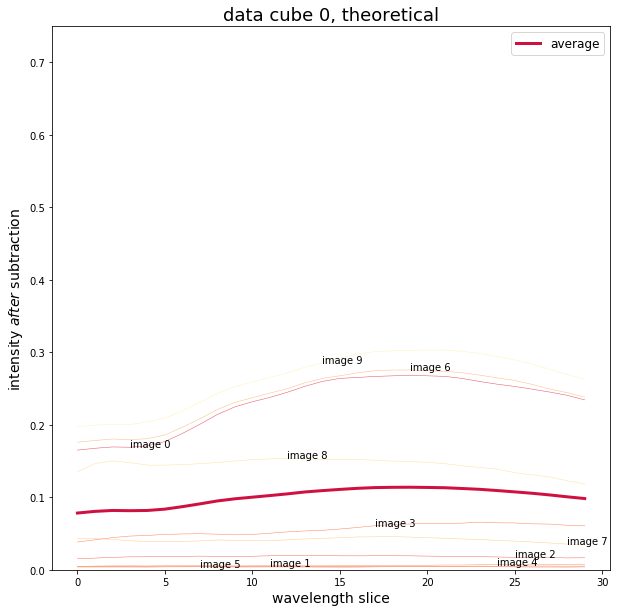

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(theo_dc0)):
    plt.plot(theo_dc0[i][:,1], #c='#ce1141', #alpha=1-i*len(theo_dc0)
             #label=f"theo{i}",
             #label=f"{np.sqrt(theo[0].positions[i][0]**2 + theo[0].positions[i][1]**2):.3f}",
             #label=f"image {i}",
             lw=.5, c=plt.cm.magma.colors[160 + 10 * i]#alpha=.5
            )
    label_loc = np.random.randint(theo_dc0.shape[1] - 1)
    plt.text(label_loc, theo_dc0[i][:,1][label_loc], f"image {i}")
    
plt.plot(theo_dc0[:,:,1].mean(axis=0), c='#ce1141', lw=3, label='average')

plt.title('data cube 0, theoretical', fontsize=18)
plt.xlabel('wavelength slice', fontsize=14)
plt.ylabel('intensity $after$ subtraction', fontsize=14)
plt.ylim(0, .75)
plt.legend(fontsize=12)

**If you did not skip the earlier `KlipRetrieve` cells**, you can examine what happened in individual slices. The subtraction for slice 20 of image 9 looks like the worst of the bunch. To examine what happened in this slice/image/alignment strategy combination (or any of them), follow this method:


********
total intensity pre-subtract:  9.3020e-01
total intensity post-subtract: 3.0322e-01
********

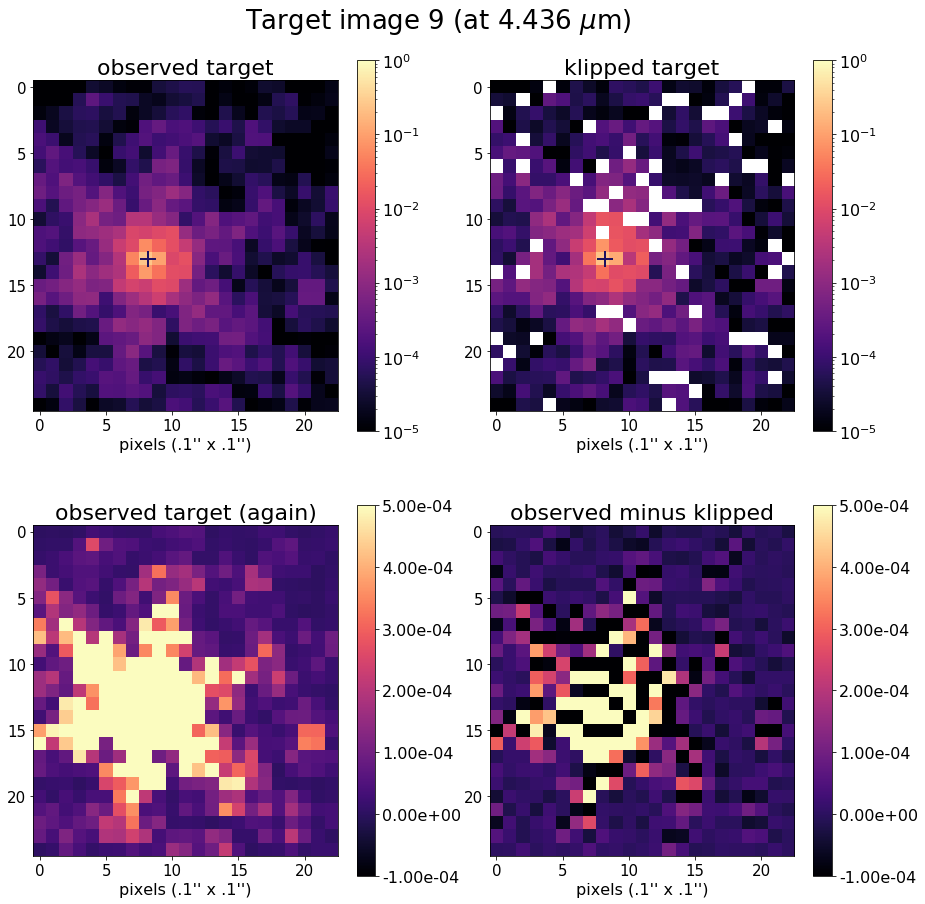

(0.9301977878673442, 0.30321596957298524)

In [ ]:
# data cube 0, image 9, slice 20
# ONLY if you did not skip KlipRetrieve cells at beginning of notebook
theo[0].plot_subtraction(target_image=9, wv_slice=20, companion=False)


********
total intensity pre-subtract:  9.3585e-01
total intensity post-subtract: 4.0072e-03
********

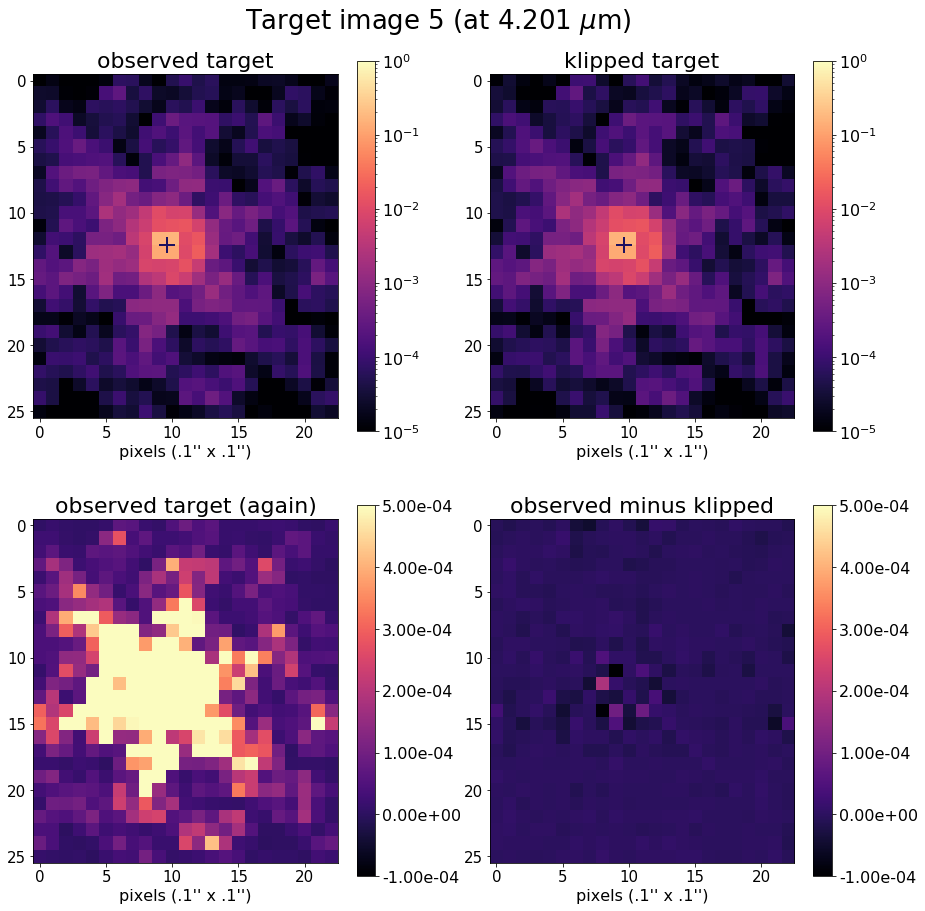

(0.9358459866110511, 0.0040071757629012526)

In [ ]:
# data cube 0, image 5, slice (any of them) looks a lot better
# ONLY if you did not skip KlipRetrieve cells at beginning of notebook
theo[0].plot_subtraction(target_image=5, wv_slice=17, companion=False)

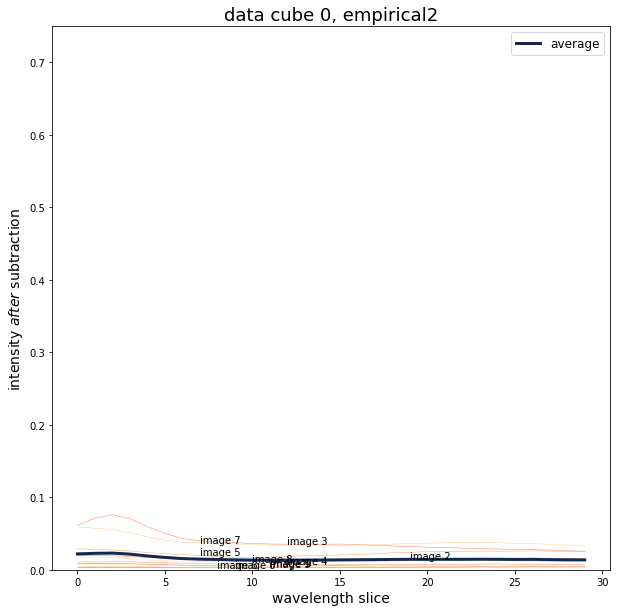

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(emp2_dc0)):
    plt.plot(emp2_dc0[i][:,1], #c='#ce1141', #alpha=1-i*len(emp2_dc0)
             #label=f"image {i}",
             lw=.5,
             c=plt.cm.magma.colors[160 + 10 * i]
            )
    label_loc = np.random.randint(emp2_dc0.shape[1] - 1)
    plt.text(label_loc, emp2_dc0[i][:,1][label_loc], f"image {i}")
    
plt.plot(emp2_dc0[:,:,1].mean(axis=0), c='#13274f', lw=3, label='average')

plt.title('data cube 0, empirical2', fontsize=18)
plt.xlabel('wavelength slice', fontsize=14)
plt.ylabel('intensity $after$ subtraction', fontsize=14)
plt.ylim(0, .75)
plt.legend(fontsize=12)

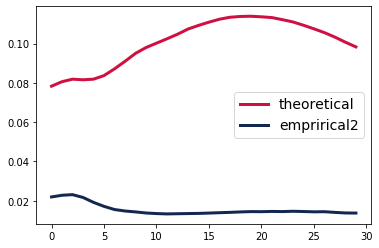

In [ ]:
plt.plot(theo_dc0[:,:,1].mean(axis=0), c='#ce1141', lw=3, label='theoretical')
plt.plot(emp2_dc0[:,:,1].mean(axis=0), c='#13274f', lw=3, label='emprirical2')
plt.legend(fontsize=14)

### all images from data cube 5 (`theo[5]` and `emp_2[5]`)

**If you skipped the `KlipRetrieve` cells at the beginning of the notebook, go straight to the plots in this section.**

In [ ]:
theo_dc5 = np.zeros((n_img, # number of target images
                     n_slices, # number of wavelength slices
                     2)) # pre-subtract intensity, post-subtract intensity

emp2_dc5 = theo_dc5.copy()

In [ ]:
for i in range(n_img):
    theo_dc5[i] = [theo[5].plot_subtraction(target_image=i, wv_slice=j,
                                            companion=False, no_plot=True)
                   for j in range(n_slices)]

In [ ]:
for i in range(n_img):
    emp2_dc5[i] = [emp_2[5].plot_subtraction(target_image=i, wv_slice=j,
                                             companion=False, no_plot=True)
                   for j in range(n_slices)]

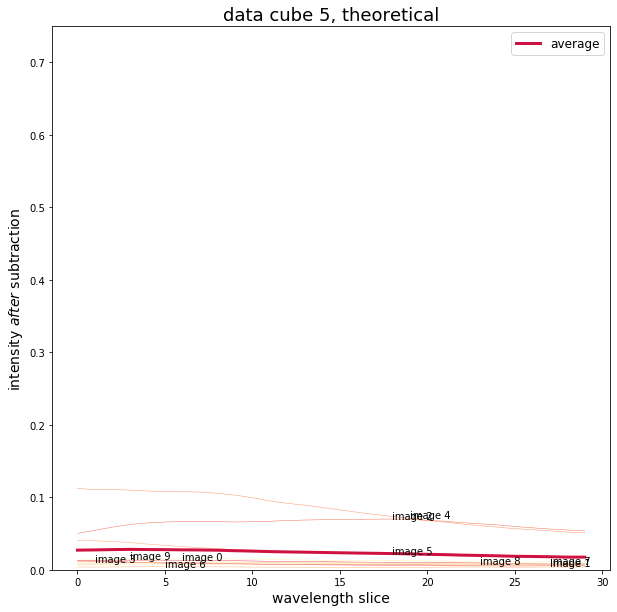

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(theo_dc0)):
    plt.plot(theo_dc5[i][:,1], #c='#ce1141', #alpha=1-i*len(theo_dc0)
             #label=f"theo{i}",
             #label=f"{np.sqrt(theo[0].positions[i][0]**2 + theo[0].positions[i][1]**2):.3f}",
             #label=f"image {i}",
             lw=.5, c=plt.cm.magma.colors[160 + 10 * i]#alpha=.5
            )
    label_loc = np.random.randint(theo_dc5.shape[1] - 1)
    plt.text(label_loc, theo_dc5[i][:,1][label_loc], f"image {i}")
    
plt.plot(theo_dc5[:,:,1].mean(axis=0), c='#ce1141', lw=3, label='average')

plt.title('data cube 5, theoretical', fontsize=18)
plt.xlabel('wavelength slice', fontsize=14)
plt.ylabel('intensity $after$ subtraction', fontsize=14)
plt.ylim(0, .75)
plt.legend(fontsize=12)

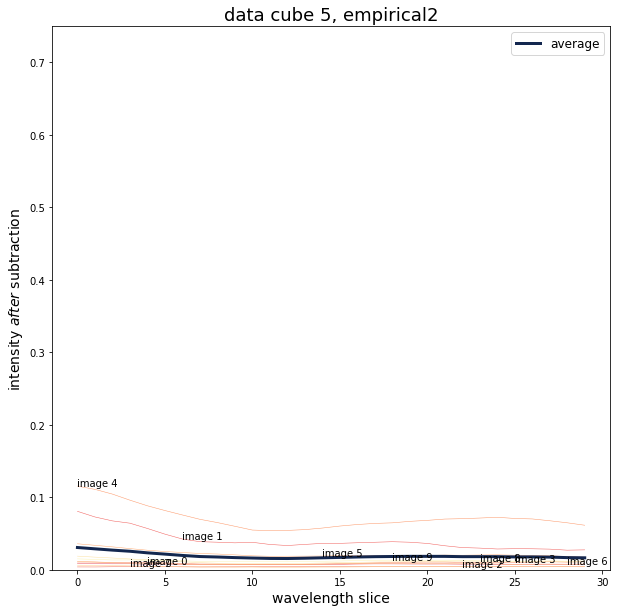

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(emp2_dc0)):
    plt.plot(emp2_dc5[i][:,1], #c='#ce1141', #alpha=1-i*len(emp2_dc0)
             #label=f"image {i}",
             lw=.5,
             c=plt.cm.magma.colors[160 + 10 * i]
            )
    label_loc = np.random.randint(emp2_dc5.shape[1] - 1)
    plt.text(label_loc, emp2_dc5[i][:,1][label_loc], f"image {i}")
    
plt.plot(emp2_dc5[:,:,1].mean(axis=0), c='#13274f', lw=3, label='average')

plt.title('data cube 5, empirical2', fontsize=18)
plt.xlabel('wavelength slice', fontsize=14)
plt.ylabel('intensity $after$ subtraction', fontsize=14)
plt.ylim(0, .75)
plt.legend(fontsize=12)

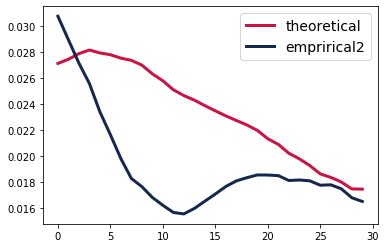

In [ ]:
plt.plot(theo_dc5[:,:,1].mean(axis=0), c='#ce1141', lw=3, label='theoretical')
plt.plot(emp2_dc5[:,:,1].mean(axis=0), c='#13274f', lw=3, label='emprirical2')
plt.legend(fontsize=14)

### all images from data cube 3 (`theo[3]` and `emp_2[3]`)

**If you skipped the `KlipRetrieve` cells at the beginning of the notebook, go straight to the plots in this section.**

In [ ]:
theo_dc3 = np.zeros((n_img, # number of target images
                     n_slices, # number of wavelength slices
                     2)) # pre-subtract intensity, post-subtract intensity

emp2_dc3 = theo_dc3.copy()

In [ ]:
for i in range(n_img):
    theo_dc3[i] = [theo[3].plot_subtraction(target_image=i, wv_slice=j,
                                            companion=False, no_plot=True)
                   for j in range(n_slices)]

In [ ]:
for i in range(n_img):
    emp2_dc3[i] = [emp_2[3].plot_subtraction(target_image=i, wv_slice=j,
                                             companion=False, no_plot=True)
                   for j in range(n_slices)]

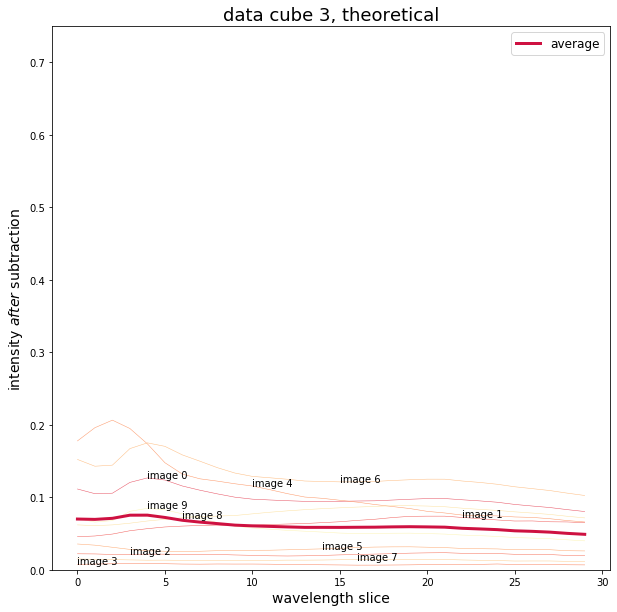

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(theo_dc0)):
    plt.plot(theo_dc3[i][:,1], #c='#ce1141', #alpha=1-i*len(theo_dc0)
             #label=f"theo{i}",
             #label=f"{np.sqrt(theo[0].positions[i][0]**2 + theo[0].positions[i][1]**2):.3f}",
             #label=f"image {i}",
             lw=.5, c=plt.cm.magma.colors[160 + 10 * i]#alpha=.5
            )
    label_loc = np.random.randint(theo_dc3.shape[1] - 1)
    plt.text(label_loc, theo_dc3[i][:,1][label_loc], f"image {i}")
    
plt.plot(theo_dc3[:,:,1].mean(axis=0), c='#ce1141', lw=3, label='average')

plt.title('data cube 3, theoretical', fontsize=18)
plt.xlabel('wavelength slice', fontsize=14)
plt.ylabel('intensity $after$ subtraction', fontsize=14)
plt.ylim(0, .75)
plt.legend(fontsize=12)

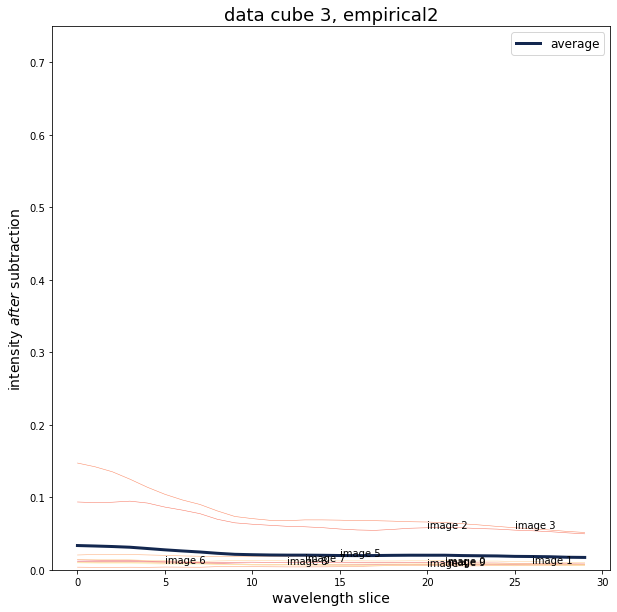

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(emp2_dc0)):
    plt.plot(emp2_dc3[i][:,1], #c='#ce1141', #alpha=1-i*len(emp2_dc0)
             #label=f"image {i}",
             lw=.5,
             c=plt.cm.magma.colors[160 + 10 * i]
            )
    label_loc = np.random.randint(emp2_dc3.shape[1] - 1)
    plt.text(label_loc, emp2_dc3[i][:,1][label_loc], f"image {i}")
    
plt.plot(emp2_dc3[:,:,1].mean(axis=0), c='#13274f', lw=3, label='average')

plt.title('data cube 3, empirical2', fontsize=18)
plt.xlabel('wavelength slice', fontsize=14)
plt.ylabel('intensity $after$ subtraction', fontsize=14)
plt.ylim(0, .75)
plt.legend(fontsize=12)

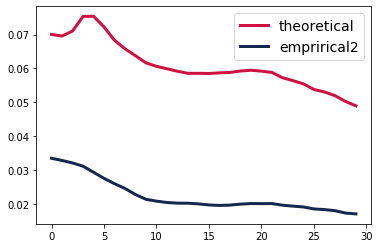

In [ ]:
plt.plot(theo_dc3[:,:,1].mean(axis=0), c='#ce1141', lw=3, label='theoretical')
plt.plot(emp2_dc3[:,:,1].mean(axis=0), c='#13274f', lw=3, label='emprirical2')
plt.legend(fontsize=14)

## The verdict.

**The `'empirical2'` alignment strategy leads to the best subtractions** in this selection of data cubes, with over 95% of the background star's flux removed in every slice tested. **As such, it will serve as the default option for the `align_style` keyword argument in `KlipRetrieve()`.**

We found it surprising that the more information-naive strategy performed the best, though the modifications made to the `'theoretical'` strategy did give it better results than it was getting in the past.

__________

### *Extra*:
To save the subtraction results so we don't have to re-run this notebook, run these cells.

In [ ]:
subtractions = {k: v for k, v in locals().items() if k.find('_dc') > 0}

In [ ]:
list(subtractions.keys())

['theo_dc0', 'emp2_dc0', 'theo_dc5', 'emp2_dc5', 'theo_dc3', 'emp2_dc3']

In [ ]:
subtractions['theo_dc0']

array([[[0.94864572, 0.16513759],
        [0.94773238, 0.16765493],
        [0.94667489, 0.16949454],
        [0.9455442 , 0.16911337],
        [0.94473094, 0.17106258],
        [0.94377453, 0.17692118],
        [0.94273798, 0.18810019],
        [0.94160689, 0.2007659 ],
        [0.94063501, 0.21429773],
        [0.93986006, 0.22477577],
        [0.93909831, 0.23181697],
        [0.9384671 , 0.23782656],
        [0.93767488, 0.24496232],
        [0.93667197, 0.25313347],
        [0.93554672, 0.25988349],
        [0.93441562, 0.2640895 ],
        [0.93334272, 0.26534659],
        [0.93233086, 0.26681195],
        [0.93135337, 0.26759401],
        [0.93040324, 0.26835506],
        [0.92964789, 0.26763346],
        [0.92875137, 0.26691248],
        [0.92791973, 0.26402851],
        [0.92687166, 0.25977549],
        [0.92594674, 0.25607049],
        [0.92478354, 0.25296179],
        [0.9234492 , 0.24921525],
        [0.92262304, 0.24520089],
        [0.92159751, 0.24072052],
        [0.920

In [ ]:
#with open('/Users/jotor/repositories/subtract-psf/notebooks/pre_post_intensities.pkl', 'wb') as file:
with open('YOUR/DESIRED/PATH', 'wb') as file:
    pickle.dump(subtractions, file)